In [246]:
######################################################
#Assignment 2
#File: prob4.py
#Author: Joshua D. Rego
#Description: 2D Transformations on Images
######################################################

In [247]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from scipy import signal
from scipy.spatial import distance
import math

In [248]:
# Utility function for plotting multiple subplots
def plot(imgs, cmap='gray', subplot_size=(1,1), figsize=(10,10), title=[None]):
    rows, columns = subplot_size #[0], img_array_size[1]
    plt.figure(figsize=figsize)
    for i in range(rows*columns):
        plt.subplot(rows, columns, i+1)
        plt.imshow(imgs[i], cmap=cmap)
        plt.title(title[i])
    plt.show()

In [249]:
debug = 0

In [250]:
##########################################################################

########## Section 4.1 - Construct white irregular quadilateral ##########
######################## and perform translation and rotation ############

In [251]:
def createQuadilateral(img_size, points): 
    # Create new Image of size 300x300
    img = Image.new('L', (h,w), 0)
    # Draw Irregular Quadilateral using corner points
    ImageDraw.Draw(img).polygon(points, outline=1, fill=1)
    # Convert image to numpy array
    img = np.array(img)
    return img

In [252]:
def translateImage(img, tx, ty):
    # Determine Translation matrix
    M_trans = np.float32([[1, 0, tx],
                          [0, 1, ty]])
    # Translate image with OpenCV cv2.warpAffine
    img_translate = cv2.warpAffine(img, M_trans, img.shape[0:2])

    if debug == 1:
        print('Translation Matrix:')
        print(M_trans)
    return img_translate

In [253]:
def rotateImage(img, theta, center, translation=[None]):    
    c_w, c_h = center
    # Rotate by 45 degrees
    theta = np.radians(theta)
    
    # Get Rotation matrix to apply on translated image
    M_rot = cv2.getRotationMatrix2D((c_w,c_h), theta, 1) 
    # Or Manually determine Rotation matrix to apply on translated image
    if translation == [None]:
        M_rot = np.float32([[ np.cos(theta), np.sin(theta), -c_w*np.cos(theta) - c_h*np.sin(theta) + c_w],
                            [-np.sin(theta), np.cos(theta),  c_w*np.sin(theta) - c_h*np.cos(theta) + c_w]])    
    # Or Manually determine Translation+Rotation matrix to apply on original image
    else:
        M_RT = np.float32([[ np.cos(theta), np.sin(theta),  tx*np.cos(theta) + ty*np.sin(theta) - c_w*np.cos(theta) - c_h*np.sin(theta) + c_h],
                           [-np.sin(theta), np.cos(theta), -tx*np.sin(theta) + ty*np.cos(theta) + c_w*np.sin(theta) - c_h*np.cos(theta) + c_h]])
    # Rotate image using OpenCV cv2.warpimage
    img_rotate = cv2.warpAffine(img, M_rot, img.shape[0:2])
    if debug == 1:
        print('Translation Matrix:')
        print(M_trans)
    return img_rotate

In [254]:
# Determine image size and center
h, w = (300,300)
c_h, c_w = h/2, w/2
# Determine corner points of irregular quadilateral
p1 = (c_w-50,c_h-50)
p2 = (c_w-20,c_h+20)
p3 = (c_w+30,c_h+25)
p4 = (c_w+40,c_h-25)

img = createQuadilateral((h,w), [p1,p2,p3,p4])

tx = 100; ty = 30
im_translate = translateImage(img, tx, ty)

theta = 45
im_rotate = rotateImage(im_translate, theta, (c_w, c_h))

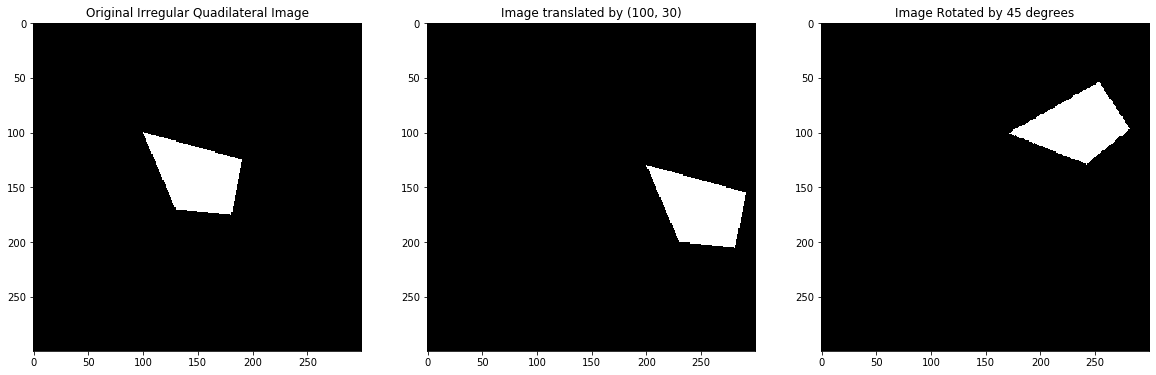

In [255]:
# Plot original, translated and rotated images
plot([img, im_translate, im_rotate], cmap='gray', subplot_size=(1,3), figsize=(20,20),
     title=['Original Irregular Quadilateral Image',
            'Image translated by (100, 30)',
            'Image Rotated by 45 degrees'])

In [256]:
##################################################################################

########## Section 4.2 - Come up with a feature detector and descriptor ##########
######################## to accurately match the four corners of #################
######################## the quadrilateral in the two pictures ###################

# Harris Corner Recipe

1. Compute image gradients over small region

2. Subtract mean from each image gradient

3. Compute the covariance matrix

4. Compute eigenvectors and eigenvalues

5. Use threshold on eigenvalues to detect corners

In [257]:
# Define function to find angles of corners using Euclidean distances
def findAngles(points):
    # Find Euclidean distances between all points
    euclidean_dist = distance.cdist(points, points, 'euclidean')
    if debug == 1:
        print('Euclidean Distances between Corner Points')
        print(euclidean_dist)
        
    # Initialize array for angles    
    angles = np.empty((0,1), dtype='float32')
    # For current corner
    for i in range(points.shape[0]):
        # Reset max angle
        angle = 0
        # Find index in Euclidean matrix for all other corners
        corners = np.nonzero(euclidean_dist[i,:])
        
        # For combinations of 2 other corner points
        for j in range(points.shape[0]-1):
            # Order for other 2 point combinations - [1,2], [1,3], [2,3]
            if j == points.shape[0] - 2:
                k = 1
                m = j
            else:
                k = 0
                m = j+1
            
            # Find line 1 between current corner and other corner 1 
            l1 = euclidean_dist[i,corners[0][k]]
            # Find line 2 between current corner and other corner 2 
            l2 = euclidean_dist[i,corners[0][m]]
            # Find line 3 between other corner 1 and other corner 2 
            l3 = euclidean_dist[corners[0][k], corners[0][m]]
            # Use Law of Cosines to find angle of current corner
            tmp_angle = np.arccos((l3**2 - l1**2 - l2**2) / (-2 * l1 * l2))
            
            # Use largest angle for current corner from combinations of other corners 
            if tmp_angle > angle:
                angle = tmp_angle
                
            if debug == 1:
                print(i, j, 'Corners:', corners)
                print('Point1', corners[0][k], 'Point2', corners[0][m],'Dist 1:', l1, 'Dist2:', l2, 'Angle:', tmp_angle)
        
        # Add final angle for current corner to final angle array
        angles = np.concatenate((angles,[[angle]]), axis=0)
    return angles

In [258]:
def findCornerCoordinates(img_copy):
    # Initialize Matrix for max values at each corner to assign single point
    corners = np.empty((0,2), dtype = 'uint16')
    # For each corner:
    for i in range(4):
        # Find the max pixel value coordinate in the entire image
        max_ind = np.unravel_index(np.argmax(img_copy, axis=None), img_copy.shape)
        # Store coordinate in corners matrix
        corners = np.concatenate((corners, [[max_ind[0], max_ind[1]]]), axis=0)
        # Assign intensities for that cluster (pixels around current max) to 0 
        img_copy[max_ind[0]-5:max_ind[0]+5, max_ind[1]-5:max_ind[1]+5] = 0
        # Repeat for new max pixel intensity coordinate
    return corners

In [259]:
# Define function to find detect corners and assign descriptors to each point
def cornerDetector(img, threshold):
    # Determine convolution kernels for x and y direction
    kern_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kern_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    # Convolve to get x and y image gradients
    I_x = signal.convolve2d(img, kern_x, mode='same')
    I_y = signal.convolve2d(img, kern_y, mode='same')
    
    # Calculate Ix^2, Iy^2, and Ixy
    I_xx = I_x**2
    I_yy = I_y**2
    I_xy = I_x * I_y
    
    k = 0.05
    # If section size = 3x3, offset = 3/2 = 1
    offset = 1
    # Initialize matrix for response at each coordinate
    h_r = np.empty((0,3), dtype='uint16')
    
    for y in range(offset, h - offset):
        for x in range(offset, w - offset):
            # Find sum of Ix^2, Iy^2, and Ixy at each sectionin each image 
            S_xx = np.sum(I_xx[y - offset:y + 1 + offset, x - offset:x + 1 + offset])
            S_yy = np.sum(I_yy[y - offset:y + 1 + offset, x - offset:x + 1 + offset])
            S_xy = np.sum(I_xy[y - offset:y + 1 + offset, x - offset:x + 1 + offset])
            
            # Calculate determinant
            det = (S_xx * S_yy) - (S_xy**2)
            # Calculate Trace
            trace = S_xx + S_yy
            # Calculate Response
            r = det - k * (trace**2)
            # Combine with current image coordinate
            resp = [[x, y, r]]
            # Add to response matrix
            h_r = np.concatenate((h_r, resp), axis=0)
            
            if debug == 1 and x < 5 and y < 2:
                print('Harris Response Check:')
                print(h_r)
                print('')    
    #Initialize matrix to view corners
    img_copy = np.zeros((h,w))
    img_corners = np.zeros((h,w))
    
    # For response in response matrix
    for i in range(h_r.shape[0]):
        x, y, r = h_r[i,0].astype('uint16'), h_r[i,1].astype('uint16'), h_r[i,2]
        # If response is larger than threshold, it is probably a corner
        if r > threshold:
            img_corners[y,x] = 1
            img_copy[y,x] = r / np.amax(h_r[:,2])
            
        if debug == 1 and i < 10:
            print('X, Y, Response Check:')
            print(x, y, r)
    
    # Find single coordinate for each corner
    corners = findCornerCoordinates(img_copy)
    # Find angles for each corner    
    angles = findAngles(corners)
    
    if debug == 1:
        print(corners, angles)
        print(angles)
        
    # Add angle to each image corner coordinate
    corner_descript = np.concatenate((corners, angles), axis=1)
    print('Corner Points and Angle Descriptor')
    print(corner_descript)
    
    if debug == 1:
        # Plot Gradients, Image, and Corners
        plot([I_x, I_y, I_xx, I_yy, img, img_corners], cmap='gray', subplot_size=(3,2), figsize=(20,20),
             title=['Image Gradient Ix',
                    'Image Gradient Iy',
                    'Image Gradient Ixx',
                    'Image Gradient Iyy',
                    'Image',
                    'Image Corners'])
    else:
        # Plot original, translated and rotated images
        plot([img, img_corners], cmap='gray', subplot_size=(1,2), figsize=(20,20),
             title=['Image',
                    'Image Corners',])
        
    return corner_descript

In [260]:
def matchFeatures(corners1, corners2):
    # Initialize location arrays for sorted image 1 and 2 matches
    loc1 = np.zeros((corners1.shape[0], 2))
    loc2 = np.zeros((corners1.shape[0], 2))
    # For each corner in image 1
    for i in range(corners1.shape[0]):
        # Initialize high initial angle error
        angle_error = 10
        # Compare to each corner in image 2
        for j in range(corners2.shape[0]):
            # Find error between descriptors (angle) of the two features
            tmp_error = np.abs(corners1[i,2] - corners2[j,2])
            # If error is less than previous error
            if tmp_error < angle_error:
                # Current coordinates match 
                angle_error = tmp_error
                # Assign current corner coordinates for image 1
                loc1[i,:] = corners1[i, 0:2]
                # Assign current corner coordinates for image 2
                loc2[i,:] = corners2[j, 0:2]
    if debug == 1:
        print('Corner Location Matches Check:')
        for j in range(loc1.shape[0]): print(loc1[j,:], loc2[j,:])
    return loc1, loc2

In [261]:
def drawMatches(img1, img2, matches, inliers = None):
    # Create a new output image that concatenates the two images together
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]
    img1 = img1.astype('uint8') * 255
    img2 = img2.astype('uint8') * 255
    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1,:] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:cols1+cols2,:] = np.dstack([img2, img2, img2])

    # draw circles, then connect a line between them
    for i in range(matches.shape[0]):
        
        (y1,x1) = matches[i,0:2]
        (y2,x2) = matches[i,2:4]
        
        # Draw circle at both co-ordinates
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw line between the two points
        if inliers is not None and inlier:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0, 255, 0), 1)
        elif inliers is not None:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0, 0, 255), 1)

        if inliers is None:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1)

    return out

Corner Points and Angle Descriptor
[[174.         180.           1.69228345]
 [125.         190.           1.63287685]
 [101.         101.           0.90952434]
 [170.         130.           2.04850067]]


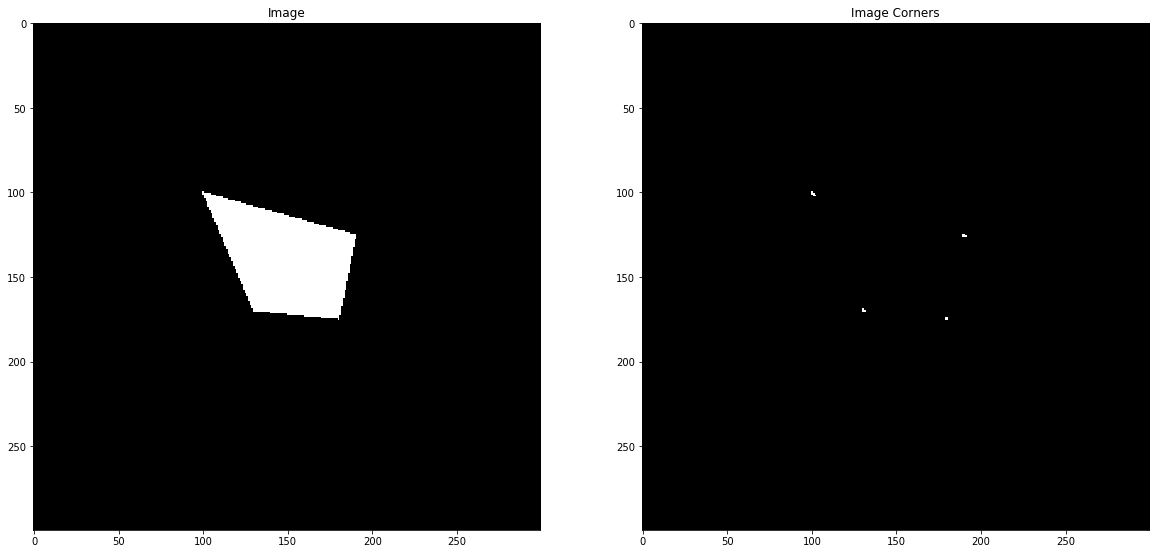

In [262]:
# Detect features and discription for original image corners
corners_original = cornerDetector(img, 600)

Corner Points and Angle Descriptor
[[204.         280.           1.69228345]
 [155.         290.           1.63287685]
 [131.         201.           0.90952434]
 [200.         230.           2.04850067]]


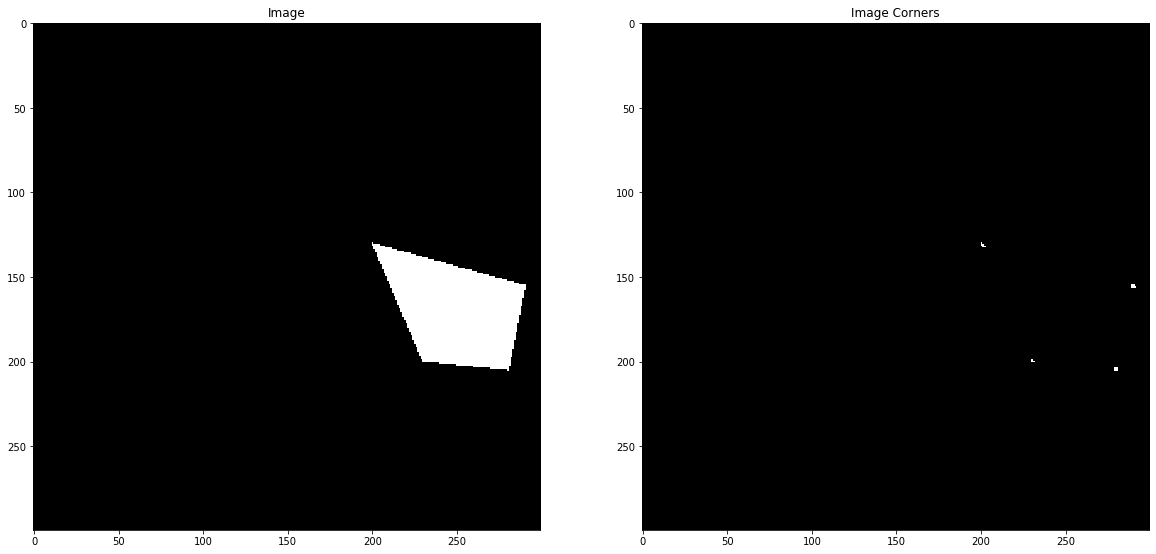

In [263]:
# Detect features and discription for translated image corners
corners_shifted = cornerDetector(im_translate, 600)

Corner Points and Angle Descriptor
[[ 97.         280.           1.69935172]
 [ 55.         253.           1.6256508 ]
 [101.         172.           0.89698938]
 [129.         242.           2.06119341]]


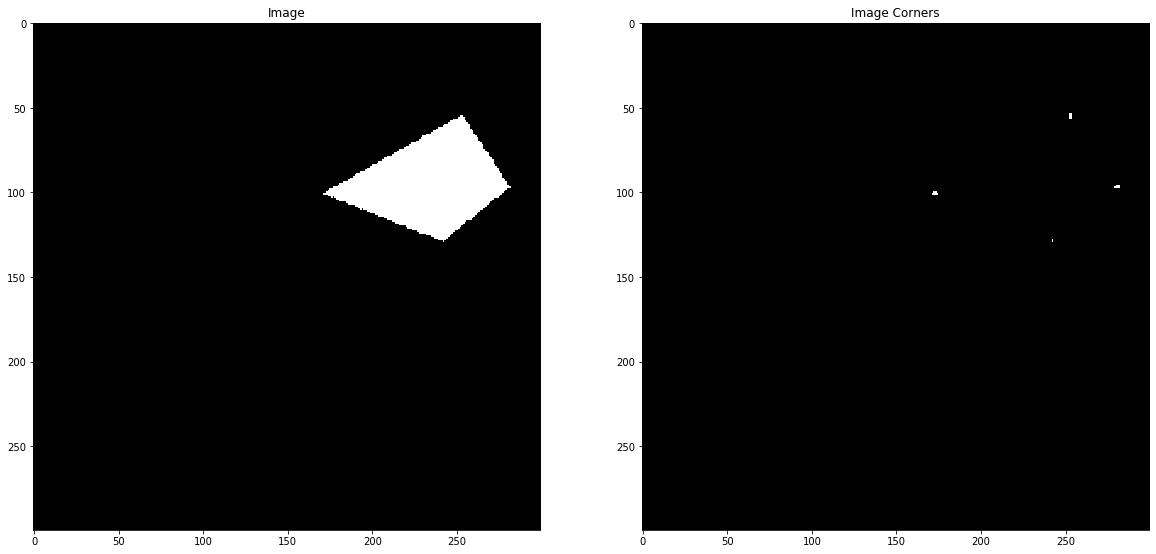

In [264]:
# Detect features and discription for rotated image corners
corners_rotate = cornerDetector(im_rotate, 600)

In [265]:
# Match features between original and rotated image and get back matched coordinates
loc1, loc2 = matchFeatures(corners_original, corners_rotate)
# Single matrix for matched points
match_points = np.concatenate((loc1,loc2), axis=1)
print('Corner Location Matches:')
print(match_points)

Corner Location Matches:
[[174. 180.  97. 280.]
 [125. 190.  55. 253.]
 [101. 101. 101. 172.]
 [170. 130. 129. 242.]]


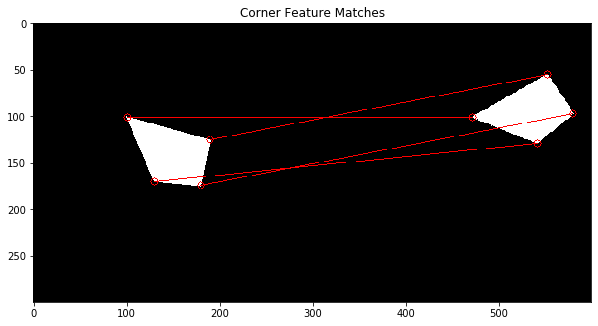

In [266]:
# get Feature matching image
matched_image = drawMatches(img, im_rotate, match_points)

# Plot matches
plot([matched_image], figsize=(10,10), title=['Corner Feature Matches'])

In [267]:
###############################################################################

########## Section 4.3 - Construct Linear Least Squares Optimization ##########
######################## to solve for Theta, tx, ty ###########################

In [268]:
def constructLLSMatrices(match_points, num_points):
    loc1, loc2 = match_points[:, 0:2], match_points[:, 2:4]
    # Initialize matrices for A and B
    A = np.empty((0,4)); B = np.empty((0,1))
    # Construct Matrix A and B
    for i in range(num_points):
        A_tmp = np.array([[loc1[i,0],  loc1[i,1], 1, 0],
                          [loc1[i,1], -loc1[i,0], 0, 1]])
        B_tmp = np.array([[loc2[i,0]], 
                          [loc2[i,1]]])
        # Add to final A and B matrix 
        A = np.concatenate((A, A_tmp), axis=0)
        B = np.concatenate((B, B_tmp), axis=0)

    if debug == 0:
        print('Matrix A'); print(A); print('')
        print('Matrix B'); print(B); print('')
    return A, B

In [275]:
# Determine number of points to be used in Linear Least Squares
num_points = 2
# Construct A and B matrices for LinearLeastSquares
A, B = constructLLSMatrices(match_points, num_points)

# Solve for Parameters with Linear Least Squares Optimization
(x, residuals, rank, s) = np.linalg.lstsq(A,B,None)

Matrix A
[[ 174.  180.    1.    0.]
 [ 180. -174.    0.    1.]
 [ 125.  190.    1.    0.]
 [ 190. -125.    0.    1.]]

Matrix B
[[ 97.]
 [280.]
 [ 55.]
 [253.]]



In [277]:
# Print Parameter Results from Linear Least Squares Optimization
print('Paramater Values:'); print(x); print('')

# Solve for Theta
theta1 = np.degrees((np.arccos(x[0])))
theta2 = np.degrees((np.arcsin(x[1])))

print('theta 1 (from cos(theta)) =', theta1)
print('theta 2 (from sin(theta)) =', theta2)
print('')

# Solve for tx, ty
#ty = (x[1]/((x[1]**2) + x[0])) * ((((x[2] + 150*x[0] + 150*x[1] - 150)/x[1]) * x[0]) + 150*x[1] - 150*x[0] + 150 - x[3])
ty = x[3]
#tx = (x[2] - ty*x[0] + 150*x[0] + 150*x[1] - 150)/x[1]
tx = x[2]
print('tx =', tx)
print('ty =', ty)

Paramater Values:
[[ 0.71491403]
 [-0.69692123]
 [98.05077969]
 [30.05117953]]

theta 1 (from cos(theta)) = [44.36384559]
theta 2 (from sin(theta)) = [-44.18051293]

tx = [98.05077969]
ty = [30.05117953]
